In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from  sklearn import  datasets
%matplotlib inline

In [80]:
class MyDataset(Dataset):
    def __init__(self, data, targets):   #, transform=None
        self.data = data
        self.labels = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        x = torch.FloatTensor(x)
        y = torch.from_numpy(np.array(y))
        return x, y
    
    def __len__(self):
        return len(self.data)

In [81]:
data = datasets.load_iris()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = data.data
y = data.target

X = data['data']
Y = data['target']
names = data['target_names']
feature_names = data['feature_names']

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size= 0.3, random_state= True)

train_dataset = MyDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=5)

test_dataset = MyDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=5)

In [ ]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[Y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[Y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [82]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [83]:
class BN_DNN(nn.Module):
    """Feedfoward neural network with 4 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 256)
        nn.BatchNorm1d(256)    #applying batch norm
        # hidden layer 2
        self.linear2 = nn.Linear(256, 512)
        nn.BatchNorm1d(512)    #applying batch norm
        # hidden layer 3
        self.linear3 = nn.Linear(512, 128)
        nn.BatchNorm1d(128)    #applying batch norm
        # hidden layer 4
        self.linear4 = nn.Linear(128, 32)
        nn.BatchNorm1d(32)    #applying batch norm
        # output layer
        self.linear5 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 4
        out = self.linear4(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear5(out)
        return out
    
    def training_step(self, batch):
        data, labels = batch 
        out = self(data)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        data, labels = batch 
        out = self(data)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [84]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [85]:
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(test_dataloader, device)

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        # model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
input_size = 4
num_classes = 3
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [88]:
model = to_device(BN_DNN(input_size, out_size=num_classes), device)
model

BN_DNN(
  (linear1): Linear(in_features=4, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=3, bias=True)
)

In [89]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8758, val_loss: 0.5578, val_acc: 0.7111
Epoch [1], train_loss: 0.4380, val_loss: 0.3440, val_acc: 0.9333
Epoch [2], train_loss: 0.2872, val_loss: 0.2251, val_acc: 0.9556
Epoch [3], train_loss: 0.1976, val_loss: 0.1401, val_acc: 0.9556
Epoch [4], train_loss: 0.1287, val_loss: 0.1152, val_acc: 0.9778
Epoch [5], train_loss: 0.1094, val_loss: 0.0949, val_acc: 0.9778
Epoch [6], train_loss: 0.1065, val_loss: 0.1059, val_acc: 0.9556
Epoch [7], train_loss: 0.1008, val_loss: 0.0792, val_acc: 0.9778
Epoch [8], train_loss: 0.1559, val_loss: 0.0804, val_acc: 0.9778
Epoch [9], train_loss: 0.1724, val_loss: 0.0941, val_acc: 0.9778
Epoch [10], train_loss: 0.1026, val_loss: 0.0668, val_acc: 0.9778
Epoch [11], train_loss: 0.0937, val_loss: 0.0608, val_acc: 0.9778
Epoch [12], train_loss: 0.1060, val_loss: 0.0583, val_acc: 0.9778
Epoch [13], train_loss: 0.1505, val_loss: 0.0770, val_acc: 0.9778
Epoch [14], train_loss: 0.2033, val_loss: 0.1275, val_acc: 0.9556
Epoch [15], train_lo

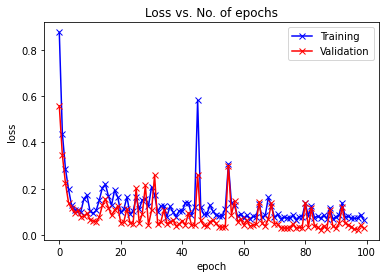

In [90]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

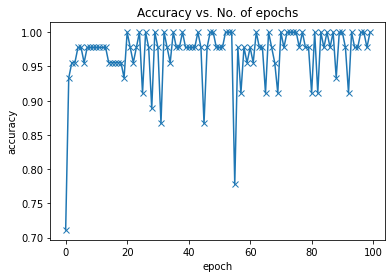

In [91]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [92]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=10), device)
result = evaluate(model, test_loader)
result

{'val_acc': 1.0, 'val_loss': 0.02913481555879116}

In [93]:
torch.save(model.state_dict(), 'BN_DNN_Iris.pth')

>loaded /content/BN_DNN_Iris.pth


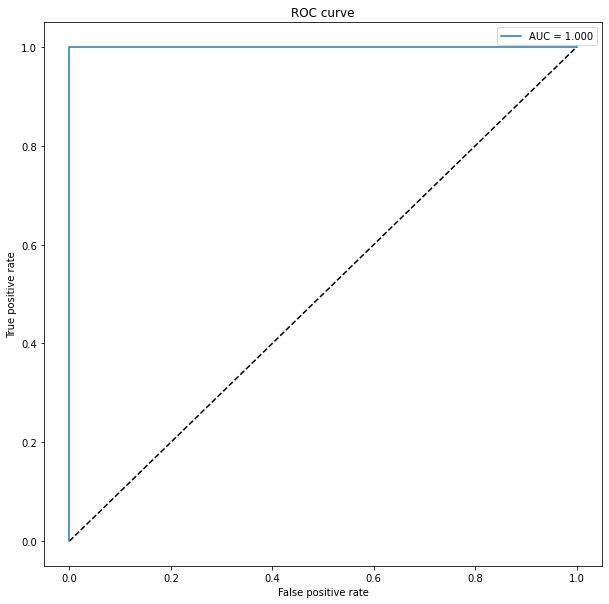

In [94]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

filename = "/content/BN_DNN_Iris.pth" 
model.load_state_dict(torch.load(filename, map_location=device))
print('>loaded %s' % filename)
model.to(device)
model.eval()
#to_device(model, device)

with torch.no_grad():
    y_pred = model(to_device(torch.FloatTensor(x_test), device))
    y_pred = y_pred.cpu().detach().numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [102]:
from torch.autograd import Variable
# Prediction
my_test = Variable(torch.from_numpy(x_test)).float()
model.to(device)
pred = model(to_device(my_test, device))

In [103]:
pred = pred.cpu().detach().numpy()
pred

array([[ 2.56255531e+01, -1.06530514e+01, -4.94905891e+01],
       [-9.21281052e+00,  9.20844841e+00, -1.40817547e+01],
       [-1.50772648e+01,  1.19055042e+01, -9.74371624e+00],
       [ 2.29639015e+01, -9.50541306e+00, -4.45524864e+01],
       [-8.66318703e+00,  2.02840477e-01,  2.16171765e+00],
       [-9.02149773e+00,  6.84017849e+00, -5.25841618e+00],
       [-7.78967237e+00,  1.66109711e-01,  1.91997528e+00],
       [ 1.66711502e+01, -5.72981787e+00, -3.63169136e+01],
       [ 1.61495323e+01, -5.50980091e+00, -3.52631874e+01],
       [-1.52244558e+01, -1.34114288e-02,  3.87620997e+00],
       [-8.33873558e+00,  6.34046984e+00, -4.93025351e+00],
       [ 1.97340164e+01, -7.43721342e+00, -4.07586021e+01],
       [-1.47588806e+01,  3.70845571e-03,  3.74752426e+00],
       [-1.24718981e+01,  9.70177650e+00, -7.66959143e+00],
       [-7.55785275e+00,  5.64764643e+00, -4.30682135e+00],
       [ 1.79070568e+01, -6.94614458e+00, -3.62826576e+01],
       [-1.28113804e+01,  1.00560713e+01

In [106]:
from sklearn.metrics import accuracy_score
print ("The accuracy is", accuracy_score(y_test, np.argmax(pred, axis=1)))

The accuracy is 1.0


In [171]:
test_loader = DeviceDataLoader(DataLoader(MyDataset(x_test,y_test), batch_size=1), device)
to_device(model, device)
result = evaluate(model, test_loader)
result

{'val_acc': 1.0, 'val_loss': 0.028297817334532738}

In [193]:
# Checking for a single instance / predicted class label
test0 = Variable(torch.from_numpy(x_test[40])).float()
to_device(model, 'cpu')
test0 = test0.reshape(1,-1)
pred0 = model(test0)
pred0 = pred0.detach().numpy()
pred1 = np.argmax(pred0, axis=1)
pred1[0]

2

In [192]:
# Actual class label
y_test[40]

2